In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle


from tensorflow.keras.layers import MultiHeadAttention,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.keras import callbacks 

from sklearn.model_selection import KFold

In [2]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6

# get spatial dimension
fname = "D:\\Code\\Fiona\\climate project\\New Data\\profiles/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

In [3]:
# spatial slicing dimensions
os = 82 # output slice size
ts = os # input slice size 32


In [4]:
#get the averaged reflectance from the dataset 
fname_r = "data_reflectance.h5"
hf_r = h5py.File(fname_r, 'r')
r=hf_r['dataset_reflectance']
r.shape


(4000, 82)

In [5]:
#get the averaged reflectance from the dataset 
fname_c = "data_cot.h5"
hf_c = h5py.File(fname_c, 'r')
c=hf_c['dataset_cot']
c.shape

(4000, 82)

In [6]:
c=c[:]
r=r[:]

In [11]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 3200 profiles
test_size: 800 profiles


In [12]:

def eval_model(train_image, test_image, train_label, test_label):

    ltype = 'mean_squared_error'
    type2=tf.keras.metrics.RootMeanSquaredError()

    bsize = 16
    eps = 4000

    #bi-LSTM
    input_layer = tf.keras.layers.Input(shape=(ts,1),name='Input')
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(ts,1)))(input_layer) 
    bi=Bidirectional(tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True))(bi)


    #transformer block 
    slf_attn = MultiHeadAttention(num_heads=3,key_dim=3)(bi,bi) ####understand the key_dim and num_heads
    layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(slf_attn+bi)
    dense1=tf.keras.layers.Dense(128,activation='relu')(layernorm1)
    layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(layernorm1+dense1)
    
    flat=tf.keras.layers.Flatten()(layernorm2)
    #pooling
    #avg_pool = GlobalAveragePooling1D()(layernorm2)
    #max_pool = GlobalMaxPooling1D()(layernorm2)
    #conc = concatenate([avg_pool, max_pool])

    #dense
   # dense2 = tf.keras.layers.Dense(256,activation='relu')(conc)
    drop=tf.keras.layers.Dropout(0.2)(flat)
    output = tf.keras.layers.Dense(os,activation='relu')(drop)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam',loss=['mse'],metrics=[ltype,type2])
    model.summary()

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    results
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions

In [13]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,800*4,ts)) #train: 800*4  test:800
y_train=np.zeros((5,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index] #r: radiance dataset
    y_train[count], y_test[count] = c[train_index], c[test_index] #c: cot dataset(label)
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [14]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 82, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 82, 128)      33792       Input[0][0]                      
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 82, 128)      98816       bidirectional_2[0][0]            
__________________________________________________________________________________________________
multi_head_attention_1 (MultiHe (None, 82, 128)      4763        bidirectional_3[0][0]            
                                                                 bidirectional_3[0][0]      

175/175 [==============================] - 4s 21ms/step - loss: 0.5675 - mean_squared_error: 0.5675 - root_mean_squared_error: 0.7533 - val_loss: 0.4894 - val_mean_squared_error: 0.4894 - val_root_mean_squared_error: 0.6995
Epoch 57/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5746 - mean_squared_error: 0.5746 - root_mean_squared_error: 0.7580 - val_loss: 0.5183 - val_mean_squared_error: 0.5183 - val_root_mean_squared_error: 0.7199
Epoch 58/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5927 - mean_squared_error: 0.5927 - root_mean_squared_error: 0.7698 - val_loss: 0.5136 - val_mean_squared_error: 0.5136 - val_root_mean_squared_error: 0.7167
Epoch 59/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5887 - mean_squared_error: 0.5887 - root_mean_squared_error: 0.7673 - val_loss: 0.5028 - val_mean_squared_error: 0.5028 - val_root_mean_squared_error: 0.7091
Epoch 60/4000
175/175 [==============================] - 4s 21

175/175 [==============================] - 4s 21ms/step - loss: 0.4563 - mean_squared_error: 0.4563 - root_mean_squared_error: 0.6755 - val_loss: 0.4242 - val_mean_squared_error: 0.4242 - val_root_mean_squared_error: 0.6513
Epoch 124/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4569 - mean_squared_error: 0.4569 - root_mean_squared_error: 0.6760 - val_loss: 0.4689 - val_mean_squared_error: 0.4689 - val_root_mean_squared_error: 0.6847
Epoch 125/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4693 - mean_squared_error: 0.4693 - root_mean_squared_error: 0.6850 - val_loss: 0.4401 - val_mean_squared_error: 0.4401 - val_root_mean_squared_error: 0.6634
Epoch 126/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4568 - mean_squared_error: 0.4568 - root_mean_squared_error: 0.6759 - val_loss: 0.4224 - val_mean_squared_error: 0.4224 - val_root_mean_squared_error: 0.6500
Epoch 127/4000
175/175 [==============================] - 4

175/175 [==============================] - 4s 21ms/step - loss: 0.4191 - mean_squared_error: 0.4191 - root_mean_squared_error: 0.6473 - val_loss: 0.4146 - val_mean_squared_error: 0.4146 - val_root_mean_squared_error: 0.6439
Epoch 158/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4184 - mean_squared_error: 0.4184 - root_mean_squared_error: 0.6468 - val_loss: 0.3927 - val_mean_squared_error: 0.3927 - val_root_mean_squared_error: 0.6267
Epoch 159/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4088 - mean_squared_error: 0.4088 - root_mean_squared_error: 0.6394 - val_loss: 0.4038 - val_mean_squared_error: 0.4038 - val_root_mean_squared_error: 0.6354
Epoch 160/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4244 - mean_squared_error: 0.4244 - root_mean_squared_error: 0.6514 - val_loss: 0.4069 - val_mean_squared_error: 0.4069 - val_root_mean_squared_error: 0.6379
Epoch 161/4000
175/175 [==============================] - 4

175/175 [==============================] - 4s 21ms/step - loss: 0.3848 - mean_squared_error: 0.3848 - root_mean_squared_error: 0.6203 - val_loss: 0.3841 - val_mean_squared_error: 0.3841 - val_root_mean_squared_error: 0.6197
Epoch 192/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3839 - mean_squared_error: 0.3839 - root_mean_squared_error: 0.6196 - val_loss: 0.3746 - val_mean_squared_error: 0.3746 - val_root_mean_squared_error: 0.6121- loss: 0.3834 - mean
Epoch 193/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3830 - mean_squared_error: 0.3830 - root_mean_squared_error: 0.6188 - val_loss: 0.4076 - val_mean_squared_error: 0.4076 - val_root_mean_squared_error: 0.6385
Epoch 194/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3831 - mean_squared_error: 0.3831 - root_mean_squared_error: 0.6190 - val_loss: 0.3859 - val_mean_squared_error: 0.3859 - val_root_mean_squared_error: 0.6212
Epoch 195/4000
175/175 [==============

175/175 [==============================] - 4s 21ms/step - loss: 0.3367 - mean_squared_error: 0.3367 - root_mean_squared_error: 0.5802 - val_loss: 0.3457 - val_mean_squared_error: 0.3457 - val_root_mean_squared_error: 0.5880
Epoch 260/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3425 - mean_squared_error: 0.3425 - root_mean_squared_error: 0.5852 - val_loss: 0.3639 - val_mean_squared_error: 0.3639 - val_root_mean_squared_error: 0.6033
Epoch 261/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3434 - mean_squared_error: 0.3434 - root_mean_squared_error: 0.5860 - val_loss: 0.3383 - val_mean_squared_error: 0.3383 - val_root_mean_squared_error: 0.5816
Epoch 262/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3383 - mean_squared_error: 0.3383 - root_mean_squared_error: 0.5816 - val_loss: 0.3697 - val_mean_squared_error: 0.3697 - val_root_mean_squared_error: 0.6081
Epoch 263/4000
175/175 [==============================] - 4

175/175 [==============================] - 4s 22ms/step - loss: 0.3072 - mean_squared_error: 0.3072 - root_mean_squared_error: 0.5542 - val_loss: 0.3288 - val_mean_squared_error: 0.3288 - val_root_mean_squared_error: 0.5734
Epoch 328/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3088 - mean_squared_error: 0.3088 - root_mean_squared_error: 0.5557 - val_loss: 0.3207 - val_mean_squared_error: 0.3207 - val_root_mean_squared_error: 0.5663
Epoch 329/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3109 - mean_squared_error: 0.3109 - root_mean_squared_error: 0.5576 - val_loss: 0.3196 - val_mean_squared_error: 0.3196 - val_root_mean_squared_error: 0.5654
Epoch 330/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3072 - mean_squared_error: 0.3072 - root_mean_squared_error: 0.5542 - val_loss: 0.3415 - val_mean_squared_error: 0.3415 - val_root_mean_squared_error: 0.5844
Epoch 331/4000
175/175 [==============================] - 4

175/175 [==============================] - 11s 33ms/step - loss: 58.1684 - mean_squared_error: 58.1684 - root_mean_squared_error: 7.4274 - val_loss: 12.0898 - val_mean_squared_error: 12.0898 - val_root_mean_squared_error: 3.4770
Epoch 2/4000
175/175 [==============================] - 4s 22ms/step - loss: 10.8803 - mean_squared_error: 10.8803 - root_mean_squared_error: 3.2947 - val_loss: 6.1318 - val_mean_squared_error: 6.1318 - val_root_mean_squared_error: 2.4763
Epoch 3/4000
175/175 [==============================] - 4s 21ms/step - loss: 5.8205 - mean_squared_error: 5.8205 - root_mean_squared_error: 2.4114 - val_loss: 3.3692 - val_mean_squared_error: 3.3692 - val_root_mean_squared_error: 1.8355
Epoch 4/4000
175/175 [==============================] - 4s 21ms/step - loss: 3.1483 - mean_squared_error: 3.1483 - root_mean_squared_error: 1.7730 - val_loss: 1.7186 - val_mean_squared_error: 1.7186 - val_root_mean_squared_error: 1.3110
Epoch 5/4000
175/175 [==============================] - 4s

175/175 [==============================] - 4s 21ms/step - loss: 0.5304 - mean_squared_error: 0.5304 - root_mean_squared_error: 0.7283 - val_loss: 0.4604 - val_mean_squared_error: 0.4604 - val_root_mean_squared_error: 0.6785
Epoch 70/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5291 - mean_squared_error: 0.5291 - root_mean_squared_error: 0.7274 - val_loss: 0.5031 - val_mean_squared_error: 0.5031 - val_root_mean_squared_error: 0.7093
Epoch 71/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5446 - mean_squared_error: 0.5446 - root_mean_squared_error: 0.7380 - val_loss: 0.4970 - val_mean_squared_error: 0.4970 - val_root_mean_squared_error: 0.7049
Epoch 72/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.5336 - mean_squared_error: 0.5336 - root_mean_squared_error: 0.7305 - val_loss: 0.4932 - val_mean_squared_error: 0.4932 - val_root_mean_squared_error: 0.7023
Epoch 73/4000
175/175 [==============================] - 4s 21

175/175 [==============================] - 4s 21ms/step - loss: 0.4327 - mean_squared_error: 0.4327 - root_mean_squared_error: 0.6578 - val_loss: 0.4216 - val_mean_squared_error: 0.4216 - val_root_mean_squared_error: 0.6493
Epoch 138/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4341 - mean_squared_error: 0.4341 - root_mean_squared_error: 0.6589 - val_loss: 0.4349 - val_mean_squared_error: 0.4349 - val_root_mean_squared_error: 0.6595
Epoch 139/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4377 - mean_squared_error: 0.4377 - root_mean_squared_error: 0.6615 - val_loss: 0.4098 - val_mean_squared_error: 0.4098 - val_root_mean_squared_error: 0.6401
Epoch 140/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4316 - mean_squared_error: 0.4316 - root_mean_squared_error: 0.6570 - val_loss: 0.4211 - val_mean_squared_error: 0.4211 - val_root_mean_squared_error: 0.6489
Epoch 141/4000
175/175 [==============================] - 4

175/175 [==============================] - 4s 21ms/step - loss: 0.3721 - mean_squared_error: 0.3721 - root_mean_squared_error: 0.6100 - val_loss: 0.3652 - val_mean_squared_error: 0.3652 - val_root_mean_squared_error: 0.6043
Epoch 206/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3698 - mean_squared_error: 0.3698 - root_mean_squared_error: 0.6081 - val_loss: 0.4090 - val_mean_squared_error: 0.4090 - val_root_mean_squared_error: 0.6395
Epoch 207/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3742 - mean_squared_error: 0.3742 - root_mean_squared_error: 0.6117 - val_loss: 0.3656 - val_mean_squared_error: 0.3656 - val_root_mean_squared_error: 0.6047
Epoch 208/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3626 - mean_squared_error: 0.3626 - root_mean_squared_error: 0.6021 - val_loss: 0.3812 - val_mean_squared_error: 0.3812 - val_root_mean_squared_error: 0.6174
Epoch 209/4000
175/175 [==============================] - 4

175/175 [==============================] - 4s 21ms/step - loss: 0.3296 - mean_squared_error: 0.3296 - root_mean_squared_error: 0.5741 - val_loss: 0.3481 - val_mean_squared_error: 0.3481 - val_root_mean_squared_error: 0.5900squared_error: 0.3289 - r
Epoch 272/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3481 - mean_squared_error: 0.3481 - root_mean_squared_error: 0.5900 - val_loss: 0.3336 - val_mean_squared_error: 0.3336 - val_root_mean_squared_error: 0.5776
Epoch 273/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3334 - mean_squared_error: 0.3334 - root_mean_squared_error: 0.5774 - val_loss: 0.3357 - val_mean_squared_error: 0.3357 - val_root_mean_squared_error: 0.5794
Epoch 274/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3406 - mean_squared_error: 0.3406 - root_mean_squared_error: 0.5836 - val_loss: 0.3341 - val_mean_squared_error: 0.3341 - val_root_mean_squared_error: 0.5780
Epoch 275/4000
175/175 [==========

Epoch 305/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3259 - mean_squared_error: 0.3259 - root_mean_squared_error: 0.5708 - val_loss: 0.3186 - val_mean_squared_error: 0.3186 - val_root_mean_squared_error: 0.5645
Epoch 306/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3151 - mean_squared_error: 0.3151 - root_mean_squared_error: 0.5613 - val_loss: 0.3231 - val_mean_squared_error: 0.3231 - val_root_mean_squared_error: 0.5685
Epoch 307/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3144 - mean_squared_error: 0.3144 - root_mean_squared_error: 0.5607 - val_loss: 0.3305 - val_mean_squared_error: 0.3305 - val_root_mean_squared_error: 0.5749
Epoch 308/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3145 - mean_squared_error: 0.3145 - root_mean_squared_error: 0.5607 - val_loss: 0.3221 - val_mean_squared_error: 0.3221 - val_root_mean_squared_error: 0.5675
Epoch 309/4000
175/175 [====================

175/175 [==============================] - 11s 29ms/step - loss: 63.3081 - mean_squared_error: 63.3081 - root_mean_squared_error: 7.7474 - val_loss: 11.9185 - val_mean_squared_error: 11.9185 - val_root_mean_squared_error: 3.4523
Epoch 2/4000
175/175 [==============================] - 4s 21ms/step - loss: 10.8736 - mean_squared_error: 10.8736 - root_mean_squared_error: 3.2940 - val_loss: 6.3488 - val_mean_squared_error: 6.3488 - val_root_mean_squared_error: 2.5197
Epoch 3/4000
175/175 [==============================] - 4s 22ms/step - loss: 6.0771 - mean_squared_error: 6.0771 - root_mean_squared_error: 2.4642 - val_loss: 3.7810 - val_mean_squared_error: 3.7810 - val_root_mean_squared_error: 1.9445
Epoch 4/4000
175/175 [==============================] - 4s 21ms/step - loss: 3.6165 - mean_squared_error: 3.6165 - root_mean_squared_error: 1.8999 - val_loss: 2.0396 - val_mean_squared_error: 2.0396 - val_root_mean_squared_error: 1.4281
Epoch 5/4000
175/175 [==============================] - 4s

175/175 [==============================] - 4s 22ms/step - loss: 0.5430 - mean_squared_error: 0.5430 - root_mean_squared_error: 0.7368 - val_loss: 0.4664 - val_mean_squared_error: 0.4664 - val_root_mean_squared_error: 0.6829
Epoch 70/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.5265 - mean_squared_error: 0.5265 - root_mean_squared_error: 0.7255 - val_loss: 0.4902 - val_mean_squared_error: 0.4902 - val_root_mean_squared_error: 0.7002
Epoch 71/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5441 - mean_squared_error: 0.5441 - root_mean_squared_error: 0.7376 - val_loss: 0.4736 - val_mean_squared_error: 0.4736 - val_root_mean_squared_error: 0.6882
Epoch 72/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.5395 - mean_squared_error: 0.5395 - root_mean_squared_error: 0.7345 - val_loss: 0.4980 - val_mean_squared_error: 0.4980 - val_root_mean_squared_error: 0.7057
Epoch 73/4000
175/175 [==============================] - 4s 21

175/175 [==============================] - 4s 24ms/step - loss: 0.4347 - mean_squared_error: 0.4347 - root_mean_squared_error: 0.6593 - val_loss: 0.4081 - val_mean_squared_error: 0.4081 - val_root_mean_squared_error: 0.6388
Epoch 137/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.4363 - mean_squared_error: 0.4363 - root_mean_squared_error: 0.6605 - val_loss: 0.4716 - val_mean_squared_error: 0.4716 - val_root_mean_squared_error: 0.6868
Epoch 138/4000
175/175 [==============================] - 4s 24ms/step - loss: 0.4446 - mean_squared_error: 0.4446 - root_mean_squared_error: 0.6668 - val_loss: 0.4068 - val_mean_squared_error: 0.4068 - val_root_mean_squared_error: 0.6378
Epoch 139/4000
175/175 [==============================] - 5s 27ms/step - loss: 0.4294 - mean_squared_error: 0.4294 - root_mean_squared_error: 0.6552 - val_loss: 0.4201 - val_mean_squared_error: 0.4201 - val_root_mean_squared_error: 0.6481
Epoch 140/4000
175/175 [==============================] - 4

175/175 [==============================] - 4s 22ms/step - loss: 0.3688 - mean_squared_error: 0.3688 - root_mean_squared_error: 0.6073 - val_loss: 0.3740 - val_mean_squared_error: 0.3740 - val_root_mean_squared_error: 0.6115
Epoch 204/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3741 - mean_squared_error: 0.3741 - root_mean_squared_error: 0.6116 - val_loss: 0.3626 - val_mean_squared_error: 0.3626 - val_root_mean_squared_error: 0.6021
Epoch 205/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3756 - mean_squared_error: 0.3756 - root_mean_squared_error: 0.6128 - val_loss: 0.3597 - val_mean_squared_error: 0.3597 - val_root_mean_squared_error: 0.5997
Epoch 206/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3691 - mean_squared_error: 0.3691 - root_mean_squared_error: 0.6075 - val_loss: 0.3939 - val_mean_squared_error: 0.3939 - val_root_mean_squared_error: 0.6276
Epoch 207/4000
175/175 [==============================] - 4

175/175 [==============================] - 4s 21ms/step - loss: 0.3320 - mean_squared_error: 0.3320 - root_mean_squared_error: 0.5762 - val_loss: 0.3516 - val_mean_squared_error: 0.3516 - val_root_mean_squared_error: 0.5929
Epoch 272/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3368 - mean_squared_error: 0.3368 - root_mean_squared_error: 0.5804 - val_loss: 0.3409 - val_mean_squared_error: 0.3409 - val_root_mean_squared_error: 0.5838
Epoch 273/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3317 - mean_squared_error: 0.3317 - root_mean_squared_error: 0.5759 - val_loss: 0.3623 - val_mean_squared_error: 0.3623 - val_root_mean_squared_error: 0.6019
Epoch 274/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3324 - mean_squared_error: 0.3324 - root_mean_squared_error: 0.5765 - val_loss: 0.3344 - val_mean_squared_error: 0.3344 - val_root_mean_squared_error: 0.5783
Epoch 275/4000
175/175 [==============================] - 4

Epoch 305/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3240 - mean_squared_error: 0.3240 - root_mean_squared_error: 0.5691 - val_loss: 0.3215 - val_mean_squared_error: 0.3215 - val_root_mean_squared_error: 0.5671
Epoch 306/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3204 - mean_squared_error: 0.3204 - root_mean_squared_error: 0.5661 - val_loss: 0.3536 - val_mean_squared_error: 0.3536 - val_root_mean_squared_error: 0.5947
Epoch 307/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3187 - mean_squared_error: 0.3187 - root_mean_squared_error: 0.5645 - val_loss: 0.3265 - val_mean_squared_error: 0.3265 - val_root_mean_squared_error: 0.5714
Restoring model weights from the end of the best epoch.
Epoch 00307: early stopping
test result
25/25 [==============================] - 2s 11ms/step - loss: 0.3175 - mean_squared_error: 0.3175 - root_mean_squared_error: 0.5635
MSE on test set in fold3 : 0.31753066182136536
RMSE on 

Epoch 51/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.6108 - mean_squared_error: 0.6108 - root_mean_squared_error: 0.7815 - val_loss: 0.5080 - val_mean_squared_error: 0.5080 - val_root_mean_squared_error: 0.7128
Epoch 52/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5961 - mean_squared_error: 0.5961 - root_mean_squared_error: 0.7721 - val_loss: 0.5368 - val_mean_squared_error: 0.5368 - val_root_mean_squared_error: 0.73270.5914 - 
Epoch 53/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.6050 - mean_squared_error: 0.6050 - root_mean_squared_error: 0.7778 - val_loss: 0.5025 - val_mean_squared_error: 0.5025 - val_root_mean_squared_error: 0.7089
Epoch 54/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.6056 - mean_squared_error: 0.6056 - root_mean_squared_error: 0.7782 - val_loss: 0.4859 - val_mean_squared_error: 0.4859 - val_root_mean_squared_error: 0.6971
Epoch 55/4000
175/175 [================

175/175 [==============================] - 4s 21ms/step - loss: 0.4664 - mean_squared_error: 0.4664 - root_mean_squared_error: 0.6829 - val_loss: 0.5045 - val_mean_squared_error: 0.5045 - val_root_mean_squared_error: 0.7103
Epoch 120/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4763 - mean_squared_error: 0.4763 - root_mean_squared_error: 0.6901 - val_loss: 0.4578 - val_mean_squared_error: 0.4578 - val_root_mean_squared_error: 0.6766
Epoch 121/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4582 - mean_squared_error: 0.4582 - root_mean_squared_error: 0.6769 - val_loss: 0.4124 - val_mean_squared_error: 0.4124 - val_root_mean_squared_error: 0.6422
Epoch 122/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4601 - mean_squared_error: 0.4601 - root_mean_squared_error: 0.6782 - val_loss: 0.4086 - val_mean_squared_error: 0.4086 - val_root_mean_squared_error: 0.6392
Epoch 123/4000
175/175 [==============================] - 4

175/175 [==============================] - 4s 22ms/step - loss: 0.3836 - mean_squared_error: 0.3836 - root_mean_squared_error: 0.6193 - val_loss: 0.3825 - val_mean_squared_error: 0.3825 - val_root_mean_squared_error: 0.6185
Epoch 187/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3828 - mean_squared_error: 0.3828 - root_mean_squared_error: 0.6187 - val_loss: 0.3836 - val_mean_squared_error: 0.3836 - val_root_mean_squared_error: 0.6193
Epoch 188/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3788 - mean_squared_error: 0.3788 - root_mean_squared_error: 0.6154 - val_loss: 0.3599 - val_mean_squared_error: 0.3599 - val_root_mean_squared_error: 0.5999 mean_squared_error: 0.3784
Epoch 189/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3850 - mean_squared_error: 0.3850 - root_mean_squared_error: 0.6205 - val_loss: 0.3524 - val_mean_squared_error: 0.3524 - val_root_mean_squared_error: 0.5936
Epoch 190/4000
175/175 [========

175/175 [==============================] - 4s 21ms/step - loss: 0.3425 - mean_squared_error: 0.3425 - root_mean_squared_error: 0.5853 - val_loss: 0.3492 - val_mean_squared_error: 0.3492 - val_root_mean_squared_error: 0.5909
Epoch 255/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3429 - mean_squared_error: 0.3429 - root_mean_squared_error: 0.5855 - val_loss: 0.3486 - val_mean_squared_error: 0.3486 - val_root_mean_squared_error: 0.5904
Epoch 256/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3448 - mean_squared_error: 0.3448 - root_mean_squared_error: 0.5871 - val_loss: 0.3472 - val_mean_squared_error: 0.3472 - val_root_mean_squared_error: 0.5893
Epoch 257/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3330 - mean_squared_error: 0.3330 - root_mean_squared_error: 0.5770 - val_loss: 0.3273 - val_mean_squared_error: 0.3273 - val_root_mean_squared_error: 0.5721
Epoch 258/4000
175/175 [==============================] - 4

175/175 [==============================] - 4s 21ms/step - loss: 0.3128 - mean_squared_error: 0.3128 - root_mean_squared_error: 0.5593 - val_loss: 0.3283 - val_mean_squared_error: 0.3283 - val_root_mean_squared_error: 0.5730
Epoch 323/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3153 - mean_squared_error: 0.3153 - root_mean_squared_error: 0.5615 - val_loss: 0.3414 - val_mean_squared_error: 0.3414 - val_root_mean_squared_error: 0.5843
Epoch 324/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.3097 - mean_squared_error: 0.3097 - root_mean_squared_error: 0.5565 - val_loss: 0.3298 - val_mean_squared_error: 0.3298 - val_root_mean_squared_error: 0.5743
Epoch 325/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.3186 - mean_squared_error: 0.3186 - root_mean_squared_error: 0.5644 - val_loss: 0.3191 - val_mean_squared_error: 0.3191 - val_root_mean_squared_error: 0.5649
Epoch 326/4000
175/175 [==============================] - 4

Epoch 10/4000
175/175 [==============================] - 4s 21ms/step - loss: 1.0513 - mean_squared_error: 1.0513 - root_mean_squared_error: 1.0252 - val_loss: 0.7985 - val_mean_squared_error: 0.7985 - val_root_mean_squared_error: 0.8936
Epoch 11/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.9788 - mean_squared_error: 0.9788 - root_mean_squared_error: 0.9893 - val_loss: 0.7290 - val_mean_squared_error: 0.7290 - val_root_mean_squared_error: 0.8538
Epoch 12/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.9397 - mean_squared_error: 0.9397 - root_mean_squared_error: 0.9694 - val_loss: 0.6895 - val_mean_squared_error: 0.6895 - val_root_mean_squared_error: 0.8303
Epoch 13/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.8924 - mean_squared_error: 0.8924 - root_mean_squared_error: 0.9447 - val_loss: 0.6942 - val_mean_squared_error: 0.6942 - val_root_mean_squared_error: 0.8332
Epoch 14/4000
175/175 [=========================

175/175 [==============================] - 4s 21ms/step - loss: 0.5251 - mean_squared_error: 0.5251 - root_mean_squared_error: 0.7246 - val_loss: 0.4686 - val_mean_squared_error: 0.4686 - val_root_mean_squared_error: 0.6845
Epoch 79/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5167 - mean_squared_error: 0.5167 - root_mean_squared_error: 0.7188 - val_loss: 0.5243 - val_mean_squared_error: 0.5243 - val_root_mean_squared_error: 0.7241
Epoch 80/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5281 - mean_squared_error: 0.5281 - root_mean_squared_error: 0.7267 - val_loss: 0.4683 - val_mean_squared_error: 0.4683 - val_root_mean_squared_error: 0.6843loss: 0.5260 - mean_squared_error: 0.5260 - root_me - ETA: 0s - loss: 0.5277 - mean_squared_error: 0.5277 - root_mean_squared_error
Epoch 81/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.5192 - mean_squared_error: 0.5192 - root_mean_squared_error: 0.7205 - val_loss: 0.4615 - 

175/175 [==============================] - 4s 22ms/step - loss: 0.4195 - mean_squared_error: 0.4195 - root_mean_squared_error: 0.6476 - val_loss: 0.4210 - val_mean_squared_error: 0.4210 - val_root_mean_squared_error: 0.6488
Epoch 146/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.4268 - mean_squared_error: 0.4268 - root_mean_squared_error: 0.6533 - val_loss: 0.4001 - val_mean_squared_error: 0.4001 - val_root_mean_squared_error: 0.6325
Epoch 147/4000
175/175 [==============================] - 4s 22ms/step - loss: 0.4141 - mean_squared_error: 0.4141 - root_mean_squared_error: 0.6435 - val_loss: 0.3986 - val_mean_squared_error: 0.3986 - val_root_mean_squared_error: 0.6313
Epoch 148/4000
175/175 [==============================] - 4s 21ms/step - loss: 0.4265 - mean_squared_error: 0.4265 - root_mean_squared_error: 0.6531 - val_loss: 0.4122 - val_mean_squared_error: 0.4122 - val_root_mean_squared_error: 0.6421
Epoch 149/4000
175/175 [==============================] - 4

In [15]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 0.3253 with standard deviation (0.0235)
Estimated RMSE 0.5700 with standard deviation (0.0202)


In [16]:
cv_scores

[0.31471970677375793,
 0.31915923953056335,
 0.31753066182136536,
 0.30383574962615967,
 0.3710843622684479]

In [17]:
cv_scores2

[0.560998797416687,
 0.5649418234825134,
 0.5634986162185669,
 0.5512130260467529,
 0.6091669201850891]

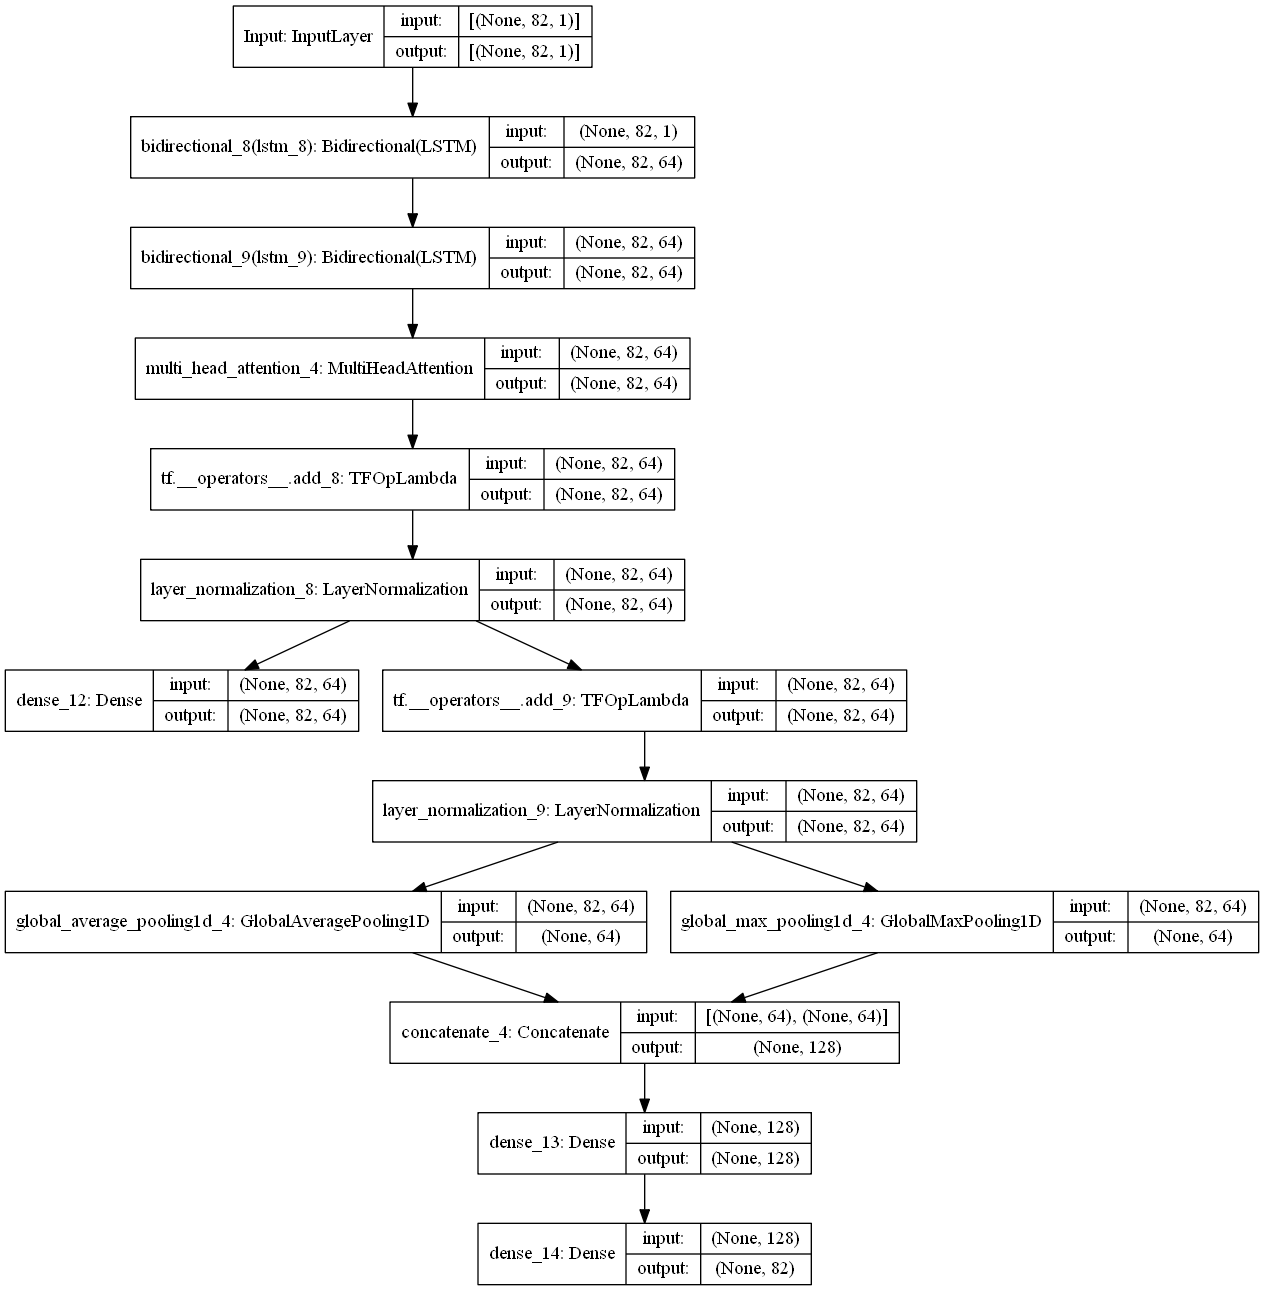

In [40]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

The optimal number of epochs is 167


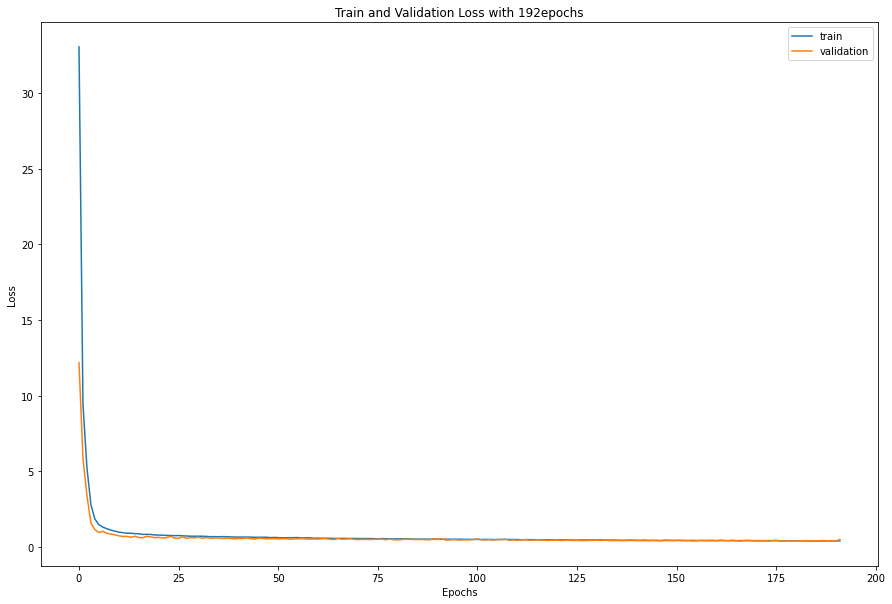

In [19]:
patience=25
# plotting training and validation history
plt.figure(figsize=(15,10))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 


plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 

plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [20]:
predictions.shape

(800, 82)

In [21]:
predict1=np.zeros(os) 
predict1=predictions[-3]
    
predict2=np.zeros((os))
predict2=predictions[-2]
    
predict3=np.zeros((os))
predict3=predictions[-1]

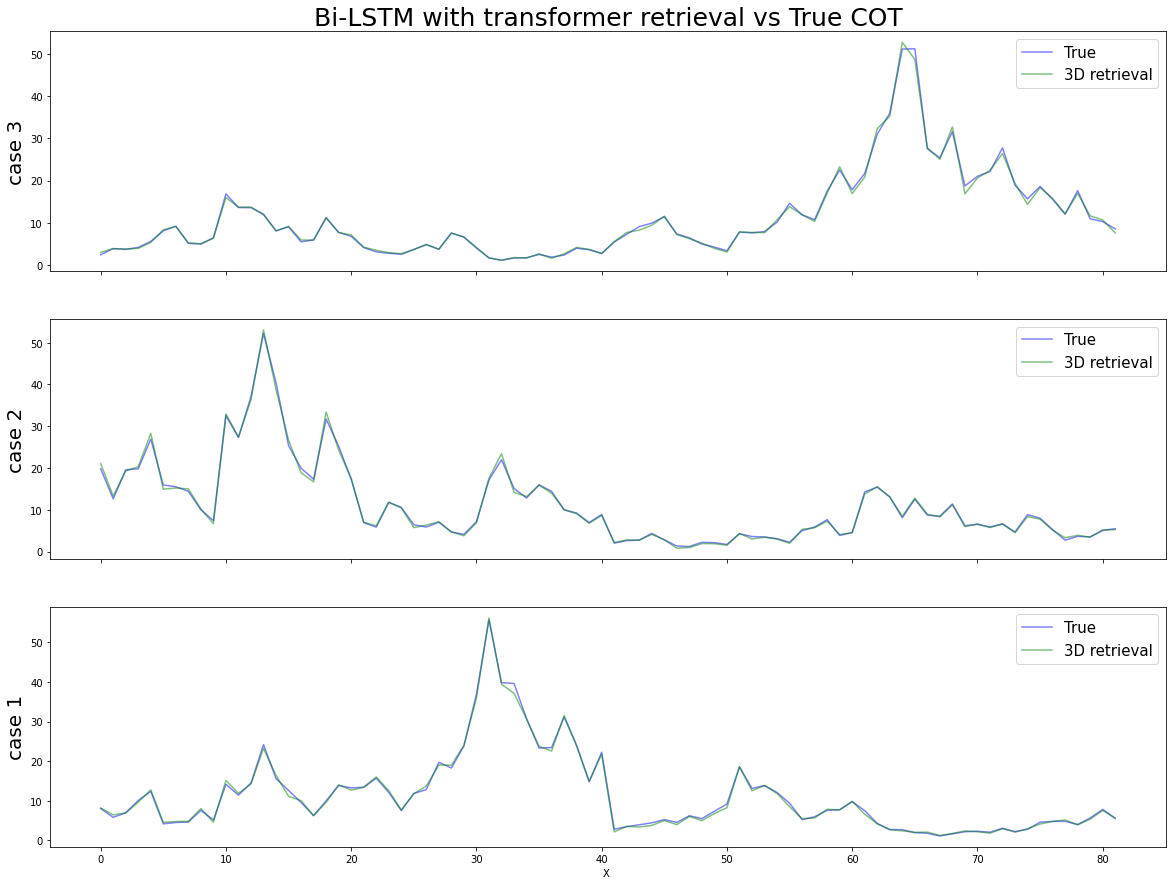

In [22]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/predict_Bi-LSTM with Transformer SZA=60 VZA=0_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with transformer retrieval vs True COT",fontsize=25)
ax.plot(range(82),test_label[800-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "3D retrieval",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"case 3",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),test_label[800-2,:],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "3D retrieval",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"case 2",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),test_label[800-1,:].T,alpha=0.5,color="blue")
ax.plot(range(82),predict3.reshape(82,),alpha=0.5,color="green")
ax.legend(["True", "3D retrieval",'1D retrieval'],fontsize=15)
ax.set_ylabel(r"case 1",fontsize=20)  
ax.set_xlabel('X ')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')



# Plotting across predicted 82 COT values

In [40]:
std=[]
mean=[]

for k in range(os):
    tmp=[]
    for j in range(800):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))
    std.append(np.std(tmp))
    mean.append(np.mean(tmp))

std=np.array(std)
mean=np.array(mean)

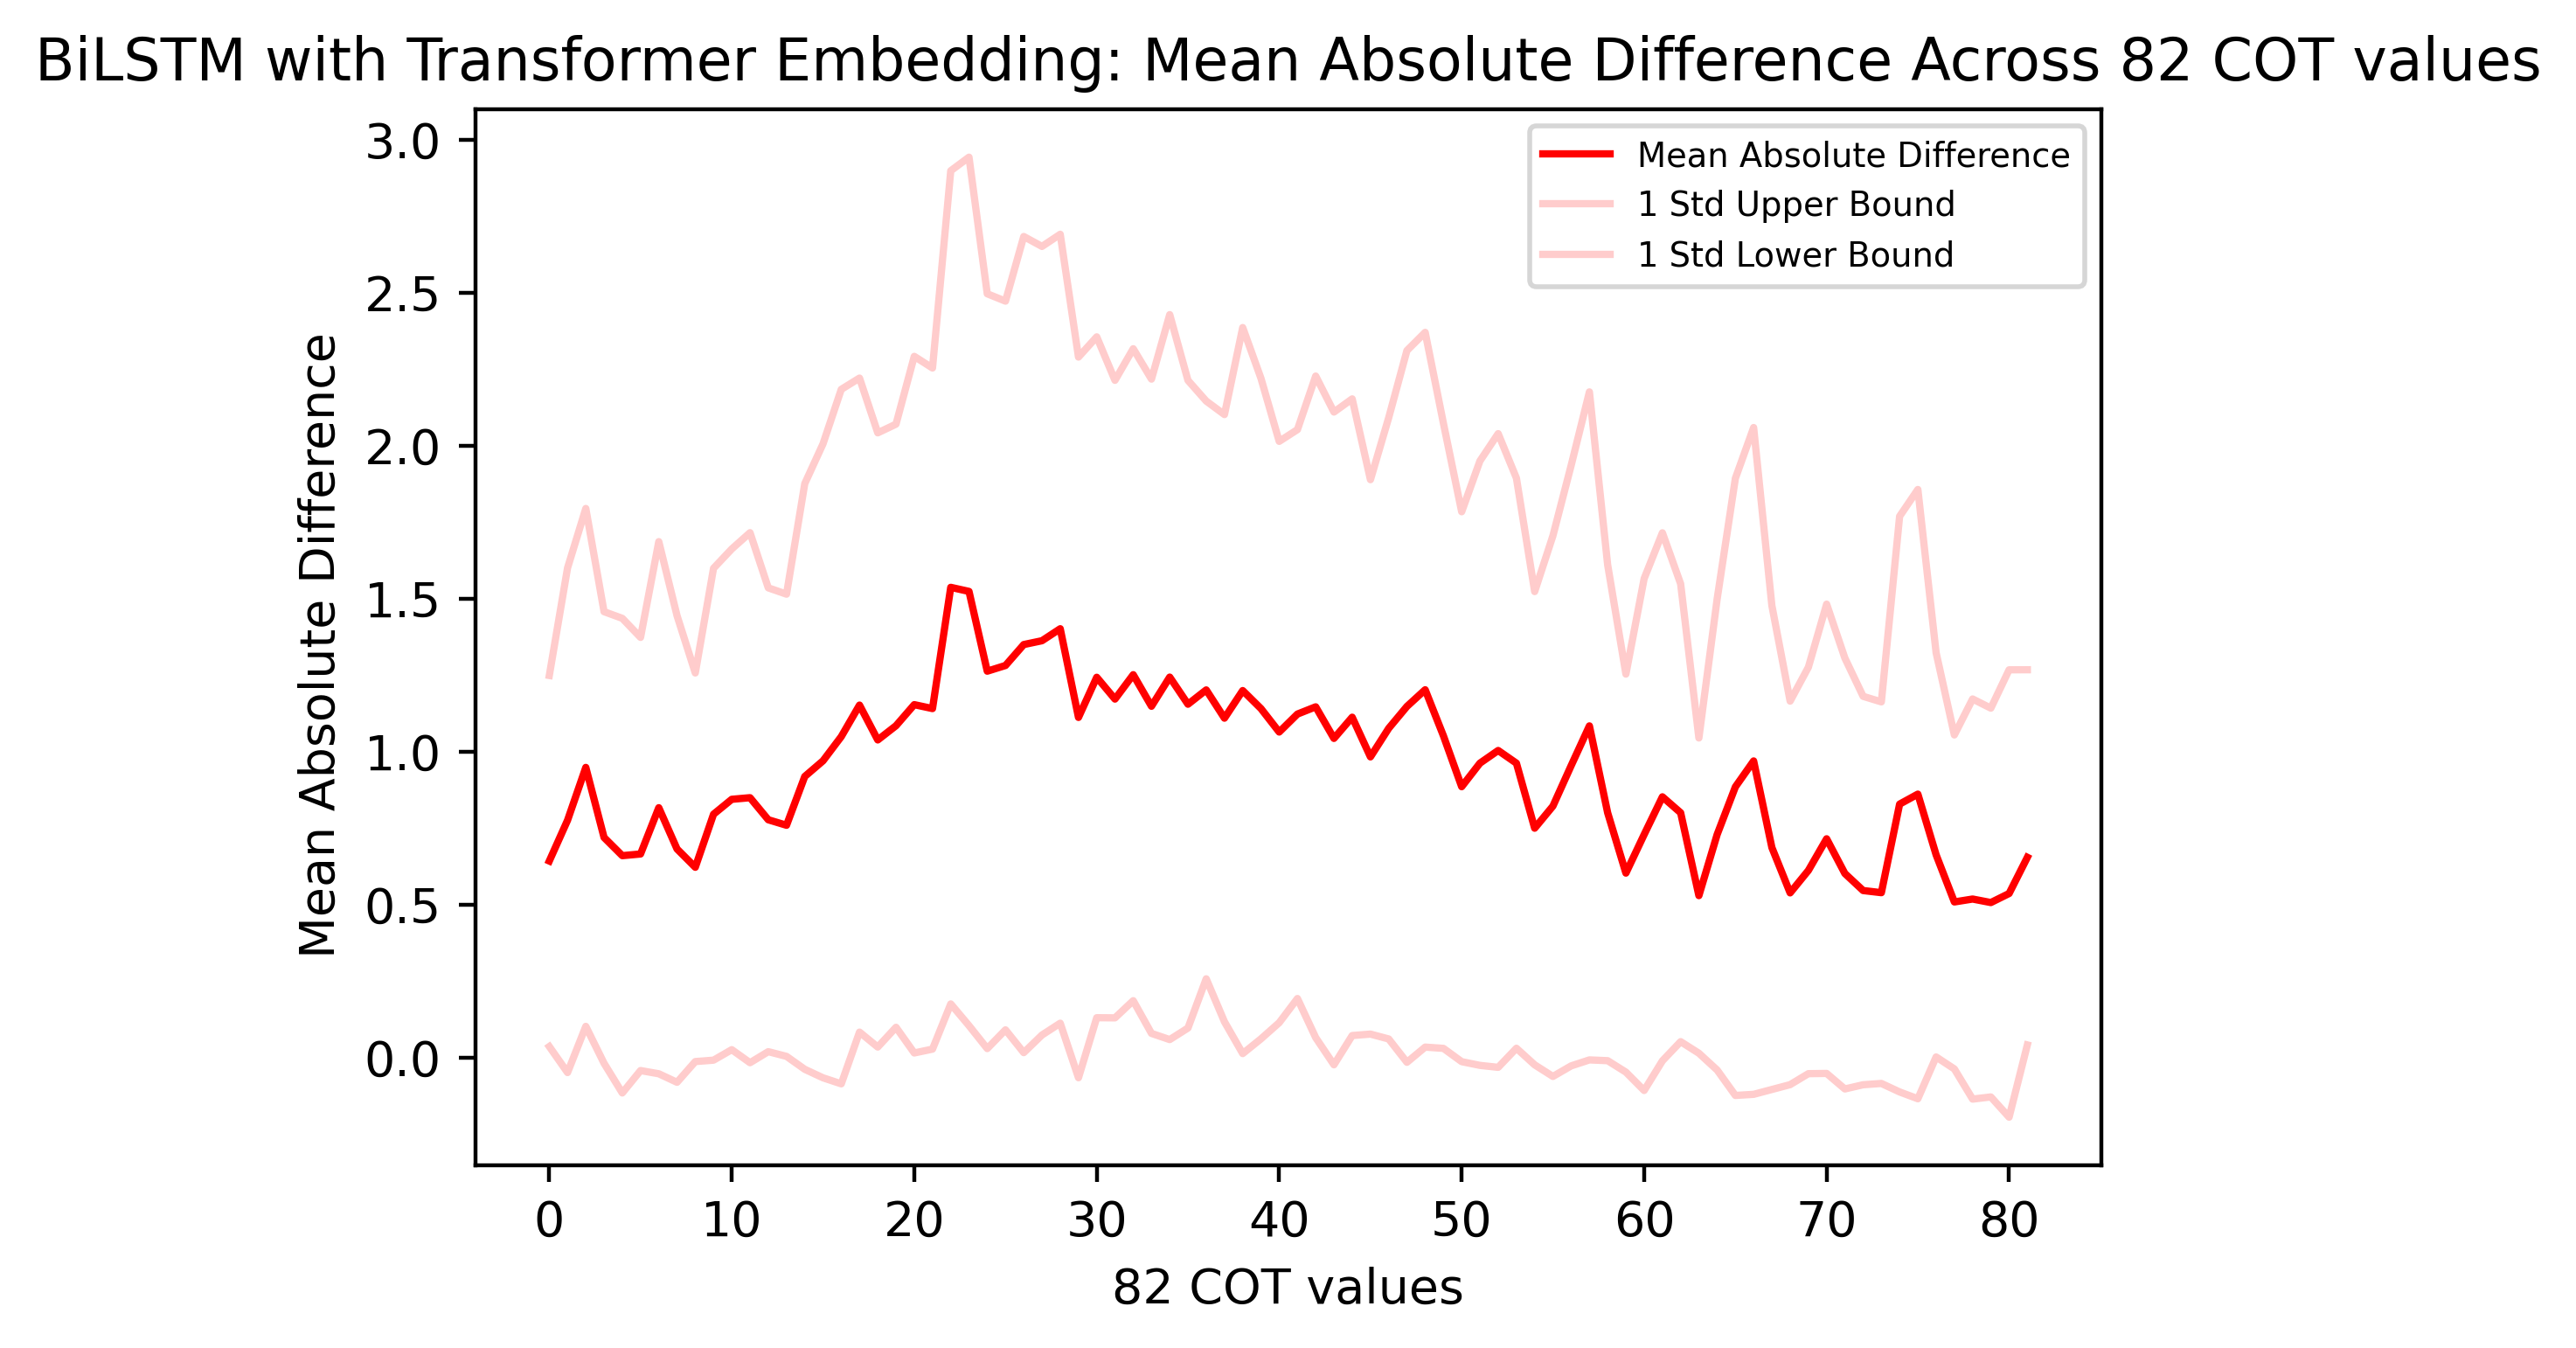

In [41]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM with Transformer Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/BiLSTM-transformer_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)

In [19]:
fname = "D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_01654.hdf5"
hf = h5py.File(fname, 'r')
physics_retrieval01654 = np.array(hf.get("Retrieved_tau"))

In [20]:
fname = 'D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_02608.hdf5'
hf = h5py.File(fname, 'r')
physics_retrieval02608 = np.array(hf.get("Retrieved_tau"))

In [21]:
fname ='D:\\code\\Fiona\\climate project\\New Data\\retrieved_COT/profile_02733.hdf5'
hf = h5py.File(fname, 'r')
physics_retrieval02733 = np.array(hf.get("Retrieved_tau"))

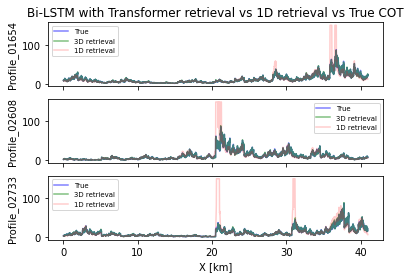

In [22]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/comparison_predict_Bi-LSTM with Transformer SZA=60 VZA=0_"+str(len(history.history['val_loss'])-patience)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with Transformer retrieval vs 1D retrieval vs True COT")
ax.plot(x[edge:os*l2r+edge],cot_data[num-3,:os*l2r],alpha=0.5,color="blue") #ground truth
ax.plot(x[edge:os*l2r+edge],predict1.reshape(4096),alpha=0.5,color="green") 
ax.plot(x[edge:os*l2r+edge],physics_retrieval01654,alpha=0.2,color="red") 
ax.legend(["True", "3D retrieval",'1D retrieval'],fontsize='x-small')
ax.set_ylabel(r"Profile_01654") 

#plot the second last profile
ax = axs[1]
ax.plot(x[edge:os*l2r+edge],cot_data[num-2,edge:os*l2r+edge],alpha=0.5,color="blue")
ax.plot(x[edge:os*l2r+edge],predict2.reshape(4096),alpha=0.5,color="green")
ax.plot(x[edge:os*l2r+edge],physics_retrieval02608,alpha=0.2,color="red")
ax.legend(["True", "3D retrieval",'1D retrieval'],fontsize='x-small')
ax.set_ylabel(r"Profile_02608")  

# plot the last profile
ax = axs[2]
ax.plot(x[edge:os*l2r+edge],cot_data[num-1,edge:os*l2r+edge].T,alpha=0.5,color="blue")
ax.plot(x[edge:os*l2r+edge],predict3.reshape(4096),alpha=0.5,color="green")
ax.plot(x[edge:os*l2r+edge],physics_retrieval02733,alpha=0.2,color="red")
ax.legend(["True", "3D retrieval",'1D retrieval'],fontsize='x-small')
ax.set_ylabel(r"Profile_02733")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')




# save model

In [50]:
# serialize model to JSON
model_json = model.to_json()
with open("bilstm-transformer-model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("bilstm-transformer-model.h5")
print("Saved model to disk")

Saved model to disk


# load model

In [51]:
# load json and create model
from keras.models import model_from_json

json_file = open('bilstm-transformer-model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("bilstm-transformer-model.h5")
print("Loaded model from disk")

Loaded model from disk


In [52]:
# evaluate loaded model on test data
ltype = 'mean_squared_error' #MSE
type2=tf.keras.metrics.RootMeanSquaredError() #RMSE
loaded_model.compile(optimizer='adam',loss=ltype,metrics=[ltype,type2])
results_rerun = loaded_model.evaluate(test_image, test_label, verbose=0)
predictions=loaded_model.predict(test_image)

In [53]:
print('test',loaded_model.metrics_names[1],results_rerun[1])
print('test',loaded_model.metrics_names[2],results_rerun[2])

test mean_squared_error 4.188384532928467
test root_mean_squared_error 2.063804864883423
